<a href="https://colab.research.google.com/github/kiannakazemi/Sales-Analysis/blob/main/SalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sales Analysis** 

Install the Prophet library.

In [ ]:
!pip install prophet

Import libraries.

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import folium
from pylab import rcParams
from itertools import combinations
from collections import Counter
from prophet import Prophet
from prophet.plot import plot_yearly
from prophet.plot import plot_plotly, plot_components_plotly

After uploading all the twelve csv files into 'SalesData' folder, I used the python concat function to merge them all into a single csv file.

In [ ]:
df = sorted(glob('./SalesData/*.csv'))
all_data = pd.concat(pd.read_csv(datafile) for datafile in df)

**Question 1. What was the best month for sales? How much was earned that month?**

In [ ]:
#dropping NAN rows
all_data = all_data.dropna(how = 'all')

#dropping rows where 'Order Date' contains 'Or' value
all_data = all_data[all_data['Order Date'].str[:2] != 'Or'] 

#add 'Month' column
all_data['Month'] = all_data['Order Date'].str[:2]
all_data['Month'] = all_data['Month'].astype('int32')

#convert 'Quantity Ordered' column type to int
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])

#convert 'Price Each' column type to float
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])

#add 'Sales' column
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']

#group by the 'Month' column and then sum up the values
results1 = all_data.groupby('Month').sum()

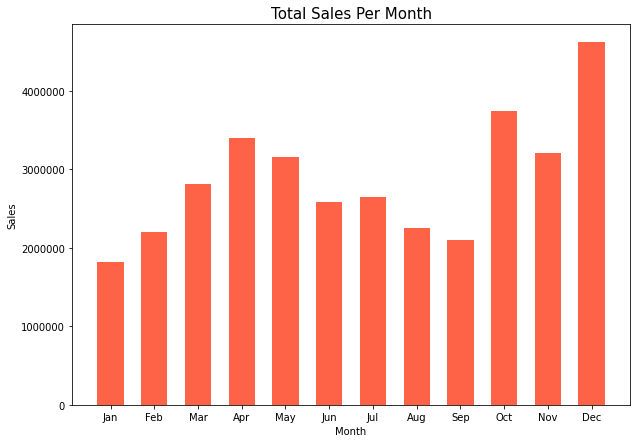

In [ ]:
#plotting the data
plt.title('Total Sales Per Month', fontdict = {'size':15})
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, results1['Sales'], color = 'tomato' , width = 0.6)
plt.gca().ticklabel_format(axis='y', style='plain')
rcParams['figure.figsize'] = 10, 7
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

**Question 2: Which city had the highest number of sales?**

In [ ]:
def get_city(address): #get_city extracts the city from the 'Purchase Address' column
    return address.split(',')[1]

def get_state(address): #get_statey extracts the state from the 'Purchase Address' column
    return address.split(',')[2].split(' ')[1]

#add 'City' column
all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)} ({get_state(x)})")

#group by the 'City' column and then sum up the values
results2 = all_data.groupby('City').sum()

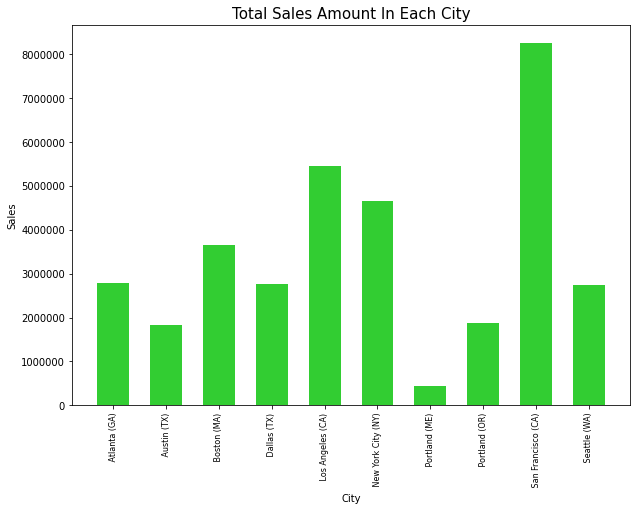

In [ ]:
#plotting the data
plt.title('Total Sales Amount In Each City', fontdict = {'size':15})
cities = [city for city, df in all_data.groupby('City')]
plt.bar(cities, results2['Sales'], color = 'limegreen', width = 0.6)
rcParams['figure.figsize'] = 10, 7
plt.xticks(cities, rotation = 'vertical', size = 8)
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xlabel('City')
plt.ylabel('Sales')
plt.show()

On the map we can see the cities with the highest number of sales with a red pin, instead the cities with a number of sales between 2.5 million and 4 million are displayed with a orange pin, and the cities with the lowest number of sales with a blue pin.

In [ ]:
#add 'Latitude' column
results2['Latitude'] = ['33.753746', '30.266666', '42.361145', '32.779167', '34.052235', '40.730610', '43.661471', '45.523064', '37.773972', '47.608013']

#add 'Longitude' column 
results2['Longitude'] = ['-84.386330', '-97.733330', '-71.057083', '-96.808891', '-118.243683', '-73.935242', ' -70.2553259', '-122.676483', '-122.431297', '-122.335167']

def select_marker_color(row): #select_marker_color returns 'red', 'orange' or 'blue' based on the number of sales 
    if row['Sales'] >= 4000000: #return 'red' if  sales >= 4000000
        return 'red'
    elif row['Sales'] >= 2500000 and row['Sales'] < 4000000: #return 'orange' if 2500000 <= sales < 4000000
        return 'orange'
    return 'blue' #return 'blue' otherwise

#add 'Color' column
results2['Color'] = results2.apply(select_marker_color, axis = 1)

#reindexing results2
results2 = results2.reset_index()

#creating map 
world_map = folium.Map(zoom_start = 4, location=[48, -102])

for _, city in results2.iterrows():
    folium.Marker(
        location=[float(city['Latitude']), float(city['Longitude'])],
        popup=city['City'],
        tooltip=city['City'],
        icon = folium.Icon(color = city['Color'], prefix='fa', icon='circle')
    ).add_to(world_map)
    
world_map

**Question 3: When is the best time to display advertisements to maximize likelihood of costumers buying product?**

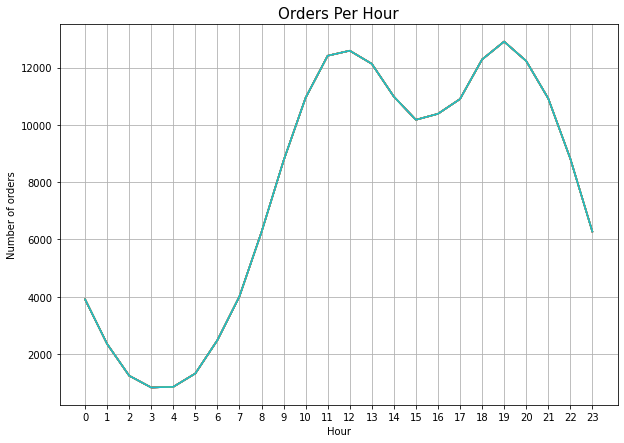

In [ ]:
#converting 'Order Date' column to datetime format
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])

#add 'Hour' column
all_data['Hour'] = all_data['Order Date'].dt.hour

#add 'Minute' column
all_data['Minute'] = all_data['Order Date'].dt.minute

#plotting the data
plt.title('Orders Per Hour', fontdict = {'size':15})
hours = [hour for hour, df in all_data.groupby('Hour')]
plt.plot(hours, all_data.groupby(['Hour']).count())
rcParams['figure.figsize'] = 10, 7
plt.xticks(hours)
plt.grid()
plt.xlabel('Hour')
plt.ylabel('Number of orders')
plt.show()

**Question 4: What products are most often sold together?**

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

#creating a new dataframe to find all the cells in 'Order ID' column that are duplicated
df = all_data[all_data['Order ID'].duplicated(keep = False)]

#add the 'Grouped' column to our new dataframe to put the products with same 'Order ID' in the same line
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

#dropping the duplicated occurences of the same pairs
df = df[['Order ID', 'Grouped']].drop_duplicates()

count = Counter()

#finding the most two products that were sold together
for row in df['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

print('The most two products that were sold together are:')

for key, value in count.most_common(10):
    print('These products were sold ', value, ' times together:\n', key)

The most two products that were sold together are:
These products were sold  1005  times together:
 ('iPhone', 'Lightning Charging Cable')
These products were sold  987  times together:
 ('Google Phone', 'USB-C Charging Cable')
These products were sold  447  times together:
 ('iPhone', 'Wired Headphones')
These products were sold  414  times together:
 ('Google Phone', 'Wired Headphones')
These products were sold  361  times together:
 ('Vareebadd Phone', 'USB-C Charging Cable')
These products were sold  360  times together:
 ('iPhone', 'Apple Airpods Headphones')
These products were sold  220  times together:
 ('Google Phone', 'Bose SoundSport Headphones')
These products were sold  160  times together:
 ('USB-C Charging Cable', 'Wired Headphones')
These products were sold  143  times together:
 ('Vareebadd Phone', 'Wired Headphones')
These products were sold  92  times together:
 ('Lightning Charging Cable', 'Wired Headphones')


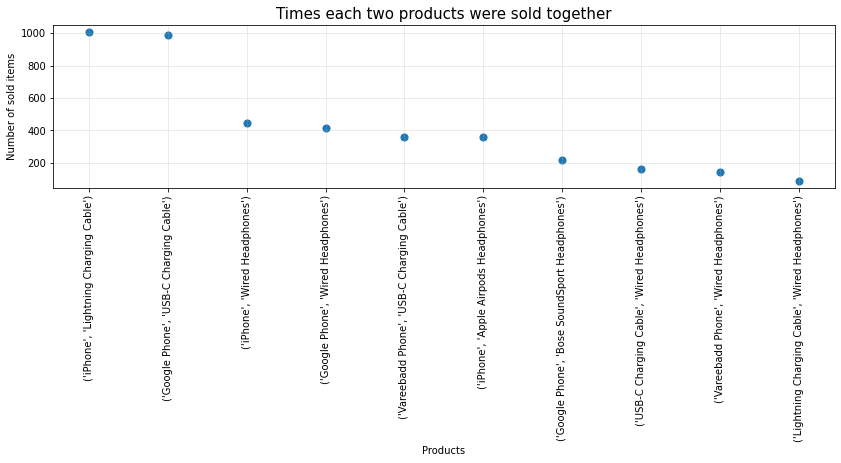

In [ ]:
#plotting the data
keys = [item[0] for item in count.most_common(10)]
values = [item[1] for item in count.most_common(10)]

plt.title('Times each two products were sold together', fontdict = {'size':15})
plt.scatter([str(i) for i in keys], values, s = 50)
plt.gcf().set_size_inches((14, 3))    
plt.xticks(rotation=90)
plt.grid(alpha=.3)
plt.xlabel('Products')
plt.ylabel('Number of sold items')
plt.show()

**Question 5: What products sold the most?**

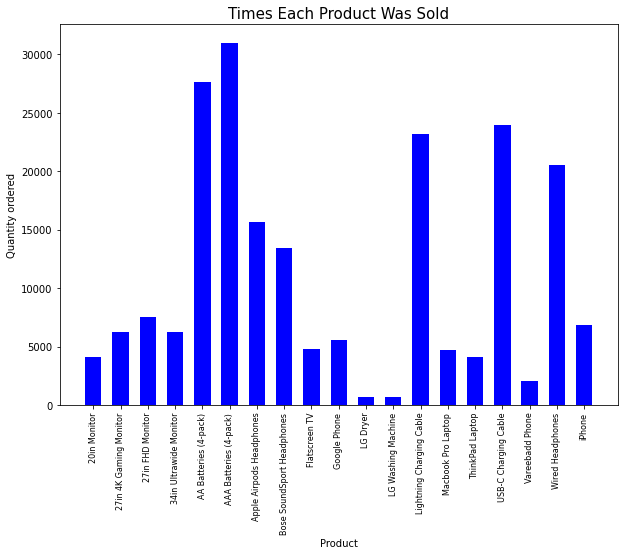

In [ ]:
#group by the 'Product' column and then sum up the 'Quantity Ordered' values
product_group = all_data.groupby('Product')
quantity_ordered = product_group.sum()['Quantity Ordered']

#plotting the data
plt.title('Times Each Product Was Sold', fontdict = {'size':15})
products = [product for product, df in product_group]
plt.bar(products, quantity_ordered, color = 'blue', width = 0.6)
rcParams['figure.figsize'] = 10, 7
plt.xticks(products, rotation = 'vertical', size = 8)
plt.xlabel('Product')
plt.ylabel('Quantity ordered')
plt.show()

I overlayed the graph with the actual prices of the items to see if there is a direct correlation between them.

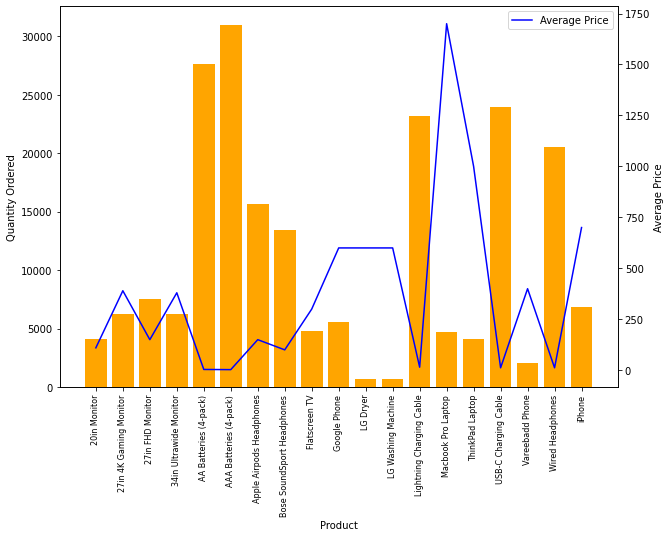

In [ ]:
#group by the 'Product' column and calculate the average price the items were sold for 
prices = all_data.groupby('Product').mean()['Price Each'] 

#overlay the prices data on the graph
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color = 'orange')
ax2.plot(products, prices, color='blue')
ax1.set_xlabel('Product')
ax1.set_ylabel('Quantity Ordered')
ax2.set_ylabel('Average Price')
plt.legend(['Average Price'], loc = 'upper right')
ax1.set_xticklabels(products, rotation='vertical', size=8)
plt.show()

**Question 6: Predict the next year sales.**


In [ ]:
#remove time from 'Order Date' column
all_data['Order Date'] = all_data['Order Date'].dt.strftime('%Y-%m-%d')

#sum up 'Sales' in each day
frame = all_data.groupby('Order Date')['Sales'].sum()

#convert Series to DataFrame
frame = frame.to_frame()
frame = frame.reset_index()

#rename the 'Order Date' and 'Sales' columns
frame.columns = ['ds', 'y']

In [ ]:
frame

,ds,y
0,2019-01-01,65681.94
1,2019-01-02,70813.20
2,2019-01-03,47046.20
3,2019-01-04,62012.21
4,2019-01-05,46524.63
...,...,...
361,2019-12-28,134015.50
362,2019-12-29,156024.62
363,2019-12-30,152319.81
364,2019-12-31,131454.30


In [ ]:
#prepare the prophet model and then fit it
m = Prophet(interval_width = 0.95).fit(frame)

#set the prediction period to 2 years on a daily basis
future = m.make_future_dataframe(periods = 360, freq = 'D')

# predict future values
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)